# Introduction


**ASSIGNMENT DEADLINE: 11 April 2019 (Thursday) 17:00**

In this assignemnt, the task is to implement some basic components for training recurrent neural network over the NLTK dataset. Firstly, you need to implement the RNNCell operations in nn/operations.py, which are used by the layers in [nn/rnn_layers.py](nn/rnn_layer.py). Secondly, you meed to implement the forward and backward function of RNN layer in [nn/rnn_layers.py](nn/rnn_layer.py). Next, you need to implement the forward and backward function of BidirectionalRNN in [nn/rnn_layers.py](nn/rnn_layer.py). Finally, you need to tune the model structure and some hyperparameters to improve the accuracy on sentiment analysis.

**Attention**:
- *Only python3 is allowed to use in this assignment.*
- *`numpy` is utilized for computation.*
- *You do not need a GPU to for this assignment. CPU is enough.*
- *To run this Jupyter notebook, you need to install the depedent libraries as stated in [README.MD](README.MD).*
- *After you implement one function, remember to restart the notebook kernel to help it recognize your fresh code.*
- *This notebook will call the functions to be implemented by you. Therefore, you will get errors if you run this whole file before you implement all the codes.*
- *Please do not change the parameters of the functions to be implemented, otherwise your implementation cannot pass the test cases.*
- *You can call functions implemented outside of the marked coding block. But do not change existing functions, e.g., rename the function or delete some functions. Do not change the folder structure, e.g., rename the files or delete some files; *

## Foler Structure


```bash
codes/
    data/
        corpus.csv      # for nltk dataset 
        dictionary.csv  # for nltk dataset
    models/    # a example model architecture for sentiment analysis
        SentimentNet.py     # example model on nltk dataset
    nn/        # components of neural networks
        rnn_layers.py       # layer abstract for RNN; Implement code here
        loss.py         # loss function for optimization
        model.py        # model abstraction for defining and training models
        operations.py   # operation abstraction for implementing operations of the layers; Implement code here
        optimizers.py   # optimizing methods
    utils/     # some additional tools
        rnn_check_grads.py  # help you check whether your forward function and backward function are consistent
        datasets.py     # load dataset, like NLTK
        initializers.py # initializing methods to initialize parameters (like weights, bias)
        tools.py        # other useful functions, you can use it in your codes
    main.ipynb # interactive notebook, help you understand your task
    README.MD  # requirements to run main.ipynb
```

## How to Use This Notebook

This iPython notebook serves to:

- explain code structure, main APIs
- explain your task
- provide code to test your implemented functions

*You can type `jupyter lab` in the terminal to start this jupyter notebook while you are in the folder containing this file. It's much more convinient than jupyter notebook.*

# Your Task

## RNN Cell Operation

RNN cell is the basic building block of RNN, which implements the recurrent transformation at each time step of RNN. It has a hidden state vector of dimension `H` and accepts a input vector of dimension `D`. In this assignment, you are required to implement a simple type of RNN cell, formulated as follows:

\begin{equation*}
y=tanh(Wx+Uh+b),
\end{equation*}

where `x` and `h` are the input and hidden vector respectively, and `W`, `U` and `b` are kernel, recurrent_kernel and bias respectively.

## Forward

In the file [nn/operations.py](nn/operations.py), implement the forward function for `RNNCellOp` operation. (`input` is a list of two numpy arrays, `[x, h]`). The following code will test your implementation using RNNCell in nn/operations.py. RNNCell is only used for testing RNNCellOp and is not used in your final model.

In [1]:
import numpy as np
import keras
from keras import layers
# import importlib
# rnn_layers
# importlib.reload(rnn_layers)
from nn.rnn_layers import RNNCell
from utils.tools import rel_error

N, D, H = 3, 10, 4
x = np.random.uniform(size=(N, D))
prev_h = np.random.uniform(size=(N, H))

rnn_cell = RNNCell(in_features=D, units=H)
out = rnn_cell.forward([x, prev_h])
# compare with the keras implementation
keras_x = layers.Input(shape=(1, D), name='x')
keras_prev_h = layers.Input(shape=(H,), name='prev_h')
keras_rnn = layers.RNN(layers.SimpleRNNCell(H),
                       name='rnn')(keras_x, initial_state=keras_prev_h)
keras_model = keras.Model(inputs=[keras_x, keras_prev_h], 
                          outputs=keras_rnn)
keras_model.get_layer('rnn').set_weights([rnn_cell.kernel,
                                          rnn_cell.recurrent_kernel,
                                          rnn_cell.bias])
keras_out = keras_model.predict_on_batch([x[:, None, :], prev_h])

print('Relative error (<1e-5 will be fine): {}'.format(rel_error(keras_out, out)))

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Relative error (<1e-5 will be fine): 5.022806032649947e-08


## Backward

Implement the backward function for the `RNNCellOp` operation in the file [nn/operations.py](nn/operations.py). 

When you are done, restart jupyter notebook and run the following to check your backward pass via numeric gradient check. 

In [2]:
import numpy as np
from nn.rnn_layers import RNNCell
from utils.rnn_check_grads import check_grads_layer

N, D, H = 3, 10, 4
x = np.random.uniform(size=(N, D))
prev_h = np.random.uniform(size=(N, H))
in_grads = np.random.uniform(size=(N, H))

rnn_cell = RNNCell(in_features=D, units=H)
inputs = [[x, prev_h]]

check_grads_layer(rnn_cell, [x, prev_h], in_grads)

Gradient to input 0: correct
Gradient to input 1: correct
Gradient to -:rnn_cell/kernel: correct
Gradient to -:rnn_cell/recurrent_kernel: correct
Gradient to -:rnn_cell/bias: correct


Then please improve your implementation of RNNCellOp so that it can properly handle `NaN` inputs, which is used as the padding value below. **In the forward pass, the corresponding outputs of NaN inputs should be `NaN`; in the backward pass, the gradients of those `NaN` input should be zeros.** The following code will test your implementation.

In [3]:
import numpy as np
from nn.rnn_layers import RNNCell
from utils.rnn_check_grads import check_grads_layer

N, D, H = 3, 10, 4
x = np.random.uniform(size=(N, D))
# set part of input to NaN
# this situation will be encountered in the following work
x[2:, :] = np.nan
prev_h = np.random.uniform(size=(N, H))
in_grads = np.random.uniform(size=(N, H))

rnn_cell = RNNCell(in_features=D, units=H)
check_grads_layer(rnn_cell, [x, prev_h], in_grads)

Gradient to input 0: correct
Gradient to input 1: correct
Gradient to -:rnn_cell/kernel: correct
Gradient to -:rnn_cell/recurrent_kernel: correct
Gradient to -:rnn_cell/bias: correct


## RNN Layer

A RNN layer operates over a sequence of input data by calling the RNNCellOp to transform the data at each position. It records the hiddent states. 

## Forward

Please implement the function `RNN.forward(self, inputs)` in [nn/rnn_layers.py](nn/rnn_layers.py) and test your implementation using the following code. Since mini-batch SGD trains a batch of data simultaneously, we define the input data format as a numpy array of shape `(N, T, D)`, where `N` is the number of samples in a batch, `T` is the maximum length of input sequences, and `D` is the dimension of features at each time step. Since the input sequences  may have different length, `NaN` is used as the padding value, e.g. `(x1, x2, ..., xk, NaN, NaN)`. **Tips: you can utilze `np.nan_to_num(x)` to easily convert NaNs to zeros in a numpy array, and `np.isnan(x)` to get binary mask indicating which elements are NaNs.**

In [4]:
import numpy as np
import keras
from keras import layers
from nn.rnn_layers import RNN
from utils.tools import rel_error

import warnings
warnings.simplefilter('ignore', RuntimeWarning)

N, T, D, H = 2, 3, 4, 5
x = np.random.uniform(size=(N, T, D))
x[0, -1:, :] = np.nan
x[1, -2:, :] = np.nan
h0 = np.random.uniform(size=(H,))

rnn = RNN(in_features=D, units=H, h0=h0)
out = rnn.forward(x)

keras_x = layers.Input(shape=(T, D), name='x')
keras_h0 = layers.Input(shape=(H,), name='h0')
keras_rnn = layers.RNN(layers.SimpleRNNCell(H), return_sequences=True,
                       name='rnn')(keras_x, initial_state=keras_h0)
keras_model = keras.Model(inputs=[keras_x, keras_h0],
                          outputs=keras_rnn)
keras_model.get_layer('rnn').set_weights([rnn.kernel,
                                          rnn.recurrent_kernel,
                                          rnn.bias])
keras_out = keras_model.predict_on_batch([x, np.tile(h0, (N, 1))])

print('Relative error (<1e-5 will be fine): {}'.format(rel_error(keras_out, out)))

Relative error (<1e-5 will be fine): 1.5297287113010859e-07


## Backward

Please implement the function `RNN.backward(self, in_grads, inputs)` in [nn/rnn_layers.py](nn/rnn_layers.py) and test your implementation using the following code. **note the gradients passed from next time steps**. Once again: the gradients to those `NaN` input units are supposed to be zeros

In [5]:
import numpy as np
# import importlib
# import rnn_layers
# importlib.reload(rnn_layers)
from nn.rnn_layers import RNN
from utils.rnn_check_grads import check_grads_layer

N, T, D, H = 2, 3, 4, 5
x = np.random.uniform(size=(N, T, D))
x[0, -1:, :] = np.nan
x[1, -2:, :] = np.nan
in_grads = np.random.uniform(size=(N, T, H))

rnn = RNN(in_features=D, units=H)
check_grads_layer(rnn, x, in_grads)

Gradient to input: correct
Gradient to -:rnn/kernel: correct
Gradient to -:rnn/recurrent_kernel: correct
Gradient to -:rnn/bias: correct


# Bi-directional RNN Layer

Vallina RNN operates over the input sequence in one direction, so the current hiddent state cannot capture the information from the next time steps. Bi-directional RNN addresses this shortcoming by reading the input sequence in both forward and backward directions. 

Bi-directional RNN is typically implemented by running two independent RNN layers in opposite directions of the input data, and concatenating the outputs of the two RNNs. A useful function that can reverse a batch of sequence data is provided for your reference.

```python
def _reverse_temporal_data(self, x, mask):
    num_nan = np.sum(~mask, axis=1)
    reversed_x = np.array(x[:, ::-1, :])
    for i in range(num_nan.size):
        reversed_x[i] = np.roll(reversed_x[i], x.shape[1]-num_nan[i], axis=0)
    return reversed_x
```

## Forward

Please implement `BidirectionalRNN.forward(self, inputs)` [nn/rnn_layers.py](nn/rnn_layers.py) and use the following code for testing. Note that `H` is the dimension of the hidden states of one internal RNN layer, so the actual dimension of the hidden state (or output) of a Bidirectional RNN is `2*H`.

In [6]:
import numpy as np
import keras
from keras import layers
# import importlib
# import rnn_layers
# importlib.reload(rnn_layers)
from nn.rnn_layers import BidirectionalRNN
from utils.tools import rel_error

N, T, D, H = 2, 3, 4, 5
x = np.random.uniform(size=(N, T, D))
x[0, -1:, :] = np.nan
x[1, -2:, :] = np.nan
h0 = np.random.uniform(size=(H,))
hr = np.random.uniform(size=(H,))

brnn = BidirectionalRNN(in_features=D, units=H, h0=h0, hr=hr)
out = brnn.forward(x)

keras_x = layers.Input(shape=(T, D), name='x')
keras_h0 = layers.Input(shape=(H,), name='h0')
keras_hr = layers.Input(shape=(H,), name='hr')
keras_x_masked = layers.Masking(mask_value=0.)(keras_x)
keras_rnn = layers.RNN(layers.SimpleRNNCell(H), return_sequences=True)
keras_brnn = layers.Bidirectional(keras_rnn, merge_mode='concat', name='brnn')(
        keras_x_masked, initial_state=[keras_h0, keras_hr])
keras_model = keras.Model(inputs=[keras_x, keras_h0, keras_hr],
                          outputs=keras_brnn)
keras_model.get_layer('brnn').set_weights([brnn.forward_rnn.kernel,
                                           brnn.forward_rnn.recurrent_kernel, 
                                           brnn.forward_rnn.bias,
                                           brnn.backward_rnn.kernel, 
                                           brnn.backward_rnn.recurrent_kernel,
                                           brnn.backward_rnn.bias])
keras_out = keras_model.predict_on_batch([np.nan_to_num(x), np.tile(h0, (N, 1)), np.tile(hr, (N, 1))])
nan_indices = np.where(np.any(np.isnan(x), axis=2))
keras_out[nan_indices[0], nan_indices[1], :] = np.nan

print('Relative error (<1e-5 will be fine): {}'.format(rel_error(keras_out, out)))

Relative error (<1e-5 will be fine): 1.3600695986712837e-07


## Backward

Please refer to the provided forward function and implement the function `BidirectionalRNN.backward(self, inputs)` in [nn/rnn_layers.py](nn/rnn_layers.py). Test your implementation using the following code.

In [7]:
import numpy as np
# import importlib
# import rnn_layers
# importlib.reload(rnn_layers)
from nn.rnn_layers import BidirectionalRNN
from utils.rnn_check_grads import check_grads_layer

N, T, D, H = 2, 3, 4, 5
x = np.random.uniform(size=(N, T, D))
x[0, -1:, :] = np.nan
x[1, -2:, :] = np.nan
in_grads = np.random.uniform(size=(N, T, H*2))

brnn = BidirectionalRNN(in_features=D, units=H)
check_grads_layer(brnn, x, in_grads)

Gradient to input: correct
Gradient to -:brnn/forward_kernel: correct
Gradient to -:brnn/forward_recurrent_kernel: correct
Gradient to -:brnn/forward_bias: correct
Gradient to -:brnn/backward_kernel: correct
Gradient to -:brnn/backward_recurrent_kernel: correct
Gradient to -:brnn/backward_bias: correct


# Sentiment Analysis using RNNs

In this section, you are required to test your implementations above by running an ensemble NN on a sentiment analysis dataset. The dataset, `data/corpus.csv`, consists of 800 real movie comments and the corresponding labels that indicate whether the comments are positive or negative. For example:
```
POSTIVE: I absolutely LOVE Harry Potter, as you can tell already.
NEGATIVE: My dad's being stupid about brokeback mountain...
```

We provide a basic RNN architecture, which can be found in `models/SentimentNet.py`. The architecture is:
```python
FCLayer(vocab_size, 200, name='embedding')
BidirectionalRNN(RNNCell(in_features=200, units=50))
FCLayer(100, 32, name='fclayer1')
TemporalPooling()
FCLayer(32, 2, name='fclayer2')
```
Every training example has a sequences of one-hot vectors, each of which represents a word. The 1st FC layer works as an [embedding layer](https://www.tensorflow.org/versions/master/programmers_guide/embedding) to learn and retrieve the word embedding vectors. After a Bi-directional RNN layer and another FC layer, a TemporalPooling layer (see `layers.py`) is used to average a sequence of vectors into one vector, which ignores the `NaN`s. The rest of the network is similar to that for binary classification of images.

In [8]:
from utils import datasets
from models.SentimentNet import SentimentNet
from nn.loss import SoftmaxCrossEntropy, L2
from nn.optimizers import Adam
import numpy as np
np.random.seed(5242)

dataset = datasets.Sentiment()
model = SentimentNet(dataset.dictionary)
loss = SoftmaxCrossEntropy(num_class=2)

adam = Adam(lr=0.001, decay=0,
            sheduler_func=lambda lr, it: lr*0.5 if it%1000==0 else lr)
model.compile(optimizer=adam, loss=loss, regularization=L2(w=0.001))
train_results, val_results, test_results = model.train(
        dataset, 
        train_batch=20, val_batch=100, test_batch=100, 
        epochs=5, 
        val_intervals=-1, test_intervals=25, print_intervals=5)

[nltk_data] Downloading package punkt to /Users/lynnjiang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Number of training samples: 600
Number of validation samples: 100
Number of testing samples: 100
Epoch 0: 
Train iter 5/30:	acc 0.50, loss 0.69, reg loss 0.00, speed 53.28 samples/sec
Train iter 10/30:	acc 0.55, loss 0.69, reg loss 0.00, speed 76.46 samples/sec
Train iter 15/30:	acc 0.55, loss 0.68, reg loss 0.00, speed 78.73 samples/sec
Train iter 20/30:	acc 0.70, loss 0.58, reg loss 0.00, speed 60.99 samples/sec
Test acc 0.84, loss 0.49
Train iter 25/30:	acc 0.95, loss 0.43, reg loss 0.01, speed 33.01 samples/sec
Epoch 1: 
Train iter 5/30:	acc 0.85, loss 0.30, reg loss 0.02, speed 58.53 samples/sec
Train iter 10/30:	acc 0.95, loss 0.13, reg loss 0.02, speed 76.21 samples/sec
Train iter 15/30:	acc 0.95, loss 0.21, reg loss 0.02, speed 73.57 samples/sec
Train iter 20/30:	acc 1.00, loss 0.18, reg loss 0.02, speed 72.11 samples/sec
Test acc 0.92, loss 0.23
Train iter 

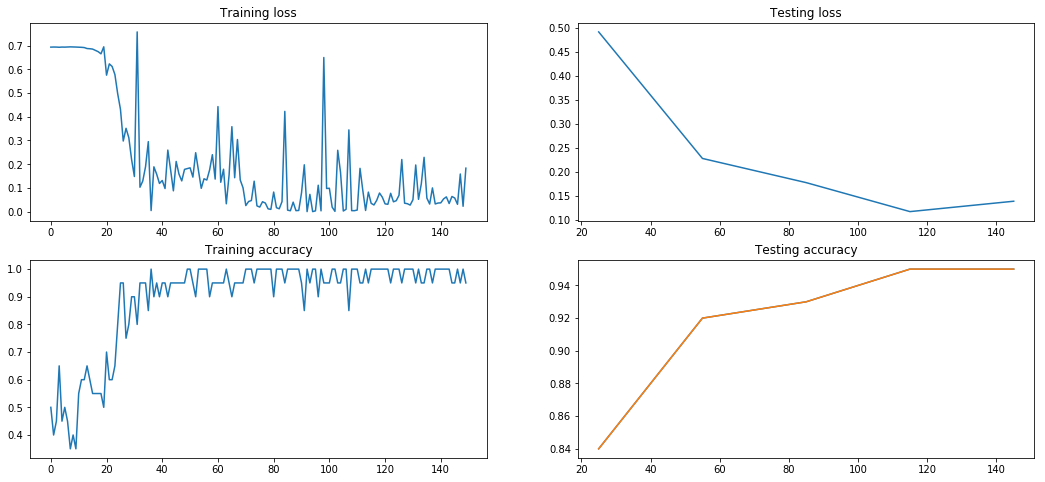

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 8))
plt.subplot(2, 2, 1)
plt.title('Training loss')
plt.plot(train_results[:,0], train_results[:,1])
plt.subplot(2, 2, 3)
plt.title('Training accuracy')
plt.plot(train_results[:,0], train_results[:,2])
plt.subplot(2, 2, 2)
plt.title('Testing loss')
plt.plot(test_results[:,0], test_results[:, 1])
plt.subplot(2, 2, 4)
plt.title('Testing accuracy')
plt.plot(test_results[:, 0], test_results[:,2])
plt.plot(test_results[:, 0], test_results[:,2])

# Train your best SentimenNet!
Tweak the hyperparameters and structure of the SentimentNet. The network is small, hence the training should finish quickly using your CPU (less than 1 hour). 

In [7]:
# define your new model and all training codes here, like loading data, defining optimizer and so on
from utils import datasets
from models.SentimentNet import SentimentNet
from nn.loss import SoftmaxCrossEntropy, L2
from nn.optimizers import Adam
import numpy as np

dataset = datasets.Sentiment()


[nltk_data] Downloading package punkt to /Users/lynnjiang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Number of training samples: 600
Number of validation samples: 100
Number of testing samples: 100


In [31]:
## Train model
np.random.seed(5242)
model = SentimentNet(dataset.dictionary)
loss = SoftmaxCrossEntropy(num_class=2)

adam = Adam(lr=0.0007, decay=0,
            sheduler_func=lambda lr, it: lr*0.5 if it%1000==0 else lr)
model.compile(optimizer=adam, loss=loss, regularization=L2(w=0.001))
train_results, val_results, test_results = model.train(
        dataset, 
        train_batch=20, val_batch=100, test_batch=100, 
        epochs=22, 
        val_intervals=-1, test_intervals=25, print_intervals=5)

Epoch 0: 
Train iter 5/30:	acc 0.60, loss 0.69, reg loss 0.00, speed 45.02 samples/sec
Train iter 10/30:	acc 0.55, loss 0.69, reg loss 0.00, speed 63.46 samples/sec
Train iter 15/30:	acc 0.70, loss 0.68, reg loss 0.00, speed 69.43 samples/sec
Train iter 20/30:	acc 0.60, loss 0.68, reg loss 0.00, speed 72.78 samples/sec
Test acc 0.60, loss 0.64
Train iter 25/30:	acc 0.50, loss 0.69, reg loss 0.00, speed 38.42 samples/sec
Epoch 1: 
Train iter 5/30:	acc 0.75, loss 0.46, reg loss 0.01, speed 56.69 samples/sec
Train iter 10/30:	acc 0.90, loss 0.19, reg loss 0.01, speed 73.49 samples/sec
Train iter 15/30:	acc 0.80, loss 0.62, reg loss 0.01, speed 73.83 samples/sec
Train iter 20/30:	acc 1.00, loss 0.06, reg loss 0.01, speed 73.70 samples/sec
Test acc 0.92, loss 0.24
Train iter 25/30:	acc 1.00, loss 0.12, reg loss 0.02, speed 38.81 samples/sec
Epoch 2: 
Train iter 5/30:	acc 0.95, loss 0.17, reg loss 0.02, speed 65.06 samples/sec
Train iter 10/30:	acc 1.00, loss 0.13, reg loss 0.02, speed 77.72

Train iter 15/30:	acc 0.95, loss 0.19, reg loss 0.02, speed 58.43 samples/sec
Train iter 20/30:	acc 1.00, loss 0.02, reg loss 0.02, speed 57.91 samples/sec
Test acc 0.96, loss 0.11
Train iter 25/30:	acc 1.00, loss 0.02, reg loss 0.02, speed 39.62 samples/sec
Epoch 20: 
Train iter 5/30:	acc 1.00, loss 0.03, reg loss 0.02, speed 51.23 samples/sec
Train iter 10/30:	acc 1.00, loss 0.01, reg loss 0.02, speed 56.79 samples/sec
Train iter 15/30:	acc 0.95, loss 0.05, reg loss 0.02, speed 48.20 samples/sec
Train iter 20/30:	acc 1.00, loss 0.01, reg loss 0.02, speed 59.18 samples/sec
Test acc 0.97, loss 0.09
Train iter 25/30:	acc 1.00, loss 0.02, reg loss 0.02, speed 36.75 samples/sec
Epoch 21: 
Train iter 5/30:	acc 1.00, loss 0.03, reg loss 0.02, speed 52.94 samples/sec
Train iter 10/30:	acc 1.00, loss 0.02, reg loss 0.02, speed 65.01 samples/sec
Train iter 15/30:	acc 1.00, loss 0.03, reg loss 0.02, speed 62.08 samples/sec
Train iter 20/30:	acc 1.00, loss 0.02, reg loss 0.02, speed 60.00 sample

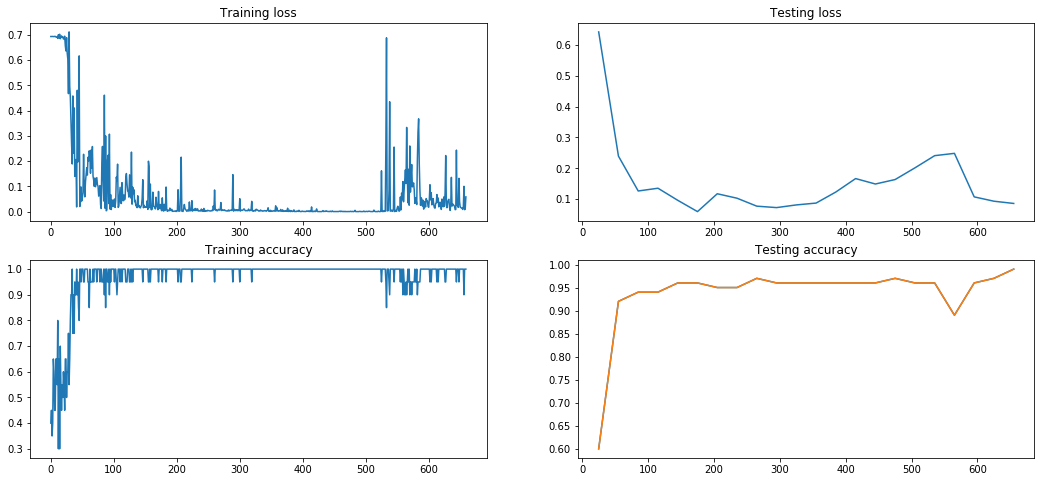

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 8))
plt.subplot(2, 2, 1)
plt.title('Training loss')
plt.plot(train_results[:,0], train_results[:,1])
plt.subplot(2, 2, 3)
plt.title('Training accuracy')
plt.plot(train_results[:,0], train_results[:,2])
plt.subplot(2, 2, 2)
plt.title('Testing loss')
plt.plot(test_results[:,0], test_results[:, 1])
plt.subplot(2, 2, 4)
plt.title('Testing accuracy')
plt.plot(test_results[:, 0], test_results[:,2])
plt.plot(test_results[:, 0], test_results[:,2])

## Your Description and Analysis
Please write down what you have tuned for your best SentimentNet. And please write down your analysis about their impacts on performance.

-----------------------------------
The test accuracy is unstable for the same model. Hence I fix the training data, validation data and test data. Besides, I also reset seed every time I run the new model. And the pamameters for the model with the best performance (test accuracy = 99%) is: {Adam(lr=0.0007, decay=0), L2(w=0.001), epochs=22}.

|Parameters    | Test Accuracy(%) | Problem|
|----------|--- |--- |
| Adam(lr=0.002, decay=0), L2(w=0.001), epochs=5 | 96 |None|
| Adam(lr=0.001, decay=0), L2(w=0.001), epochs=6 | 97 |None|
| Adam(lr=0.001, decay=0), L2(w=0.001), epochs=7 | 98 |None|
| Adam(lr=0.0009, decay=0), L2(w=0.001), epochs=30 | 91 |max=96|
| Adam(lr=0.0008, decay=0), L2(w=0.001), epochs=8 | 93 |max=97|
| Adam(lr=0.0008, decay=0), L2(w=0.001), epochs=6 | 92 |max=97|
| Adam(lr=0.0008, decay=0), L2(w=0.001), epochs=5 | 97 |None|
| Adam(lr=0.0008, decay=0), L2(w=0.001), epochs=30 | 91 |None|
| Adam(lr=0.0007, decay=0), L2(w=0.001), epochs=30 | 95 |None|
| Adam(lr=0.0007, decay=0), L2(w=0.001), epochs=22 | 99 |None|
| Adam(lr=0.0007, decay=0), L2(w=0.001), epochs=10 | 96 |None|
| Adam(lr=0.0006, decay=0), L2(w=0.001), epochs=10 | 96 |msx=97|

---

<img src="output/acc_99.png">

-----------------------------------


# Marking Scheme

Marking scheme is shown below:
- 5 marks for `RNNCellOp` forward and backward function
- 5 marks for `RNN` forward and backward function
- 5 marks for `BidirectionalRNN` backward function
- 4 marks for tuning your best SentimentNet
- 1 marks for your submission format

For submission format, please follow below submission instructions.

**DO NOT** use external libraries like Tensorflow, keras and Pytorch in your implementation. **DO NOT** copy the code from the internet, e.g. github, or your classmates.

# Final submission instructions
Please submit the following:

1) Your codes in a folder named `codes`, and keep the structure of all files in this folder the same as what we have provided. 


Do not include the `data` folder as it takes up substantial memory. Please zip up the following folders under a folder named with your NUSNET ID: eg. `e0123456g.zip` and submit the zipped folder to LumiNUS/Files/Assignment 2 Submission. If unzip the file, the structure should be like this:

```bash
e0123456g/
    codes/
        models/
            ...
        nn/
            ...
        utils/
            ...
        main.ipynb
        README.MD
```